# Multiple Knapsack Problem (Artificial Intelligence)
The problem is to pack a subset of the orders into eight vehicles, each of which has a maximum capacity of packages and weight, so that the total revenue is a maximum. Existing constraints are: Order revenue, order bonus if finished within a time window, order penality if finished after a time window, the package amount and weight of each package. The result is a sequence of orders for each vehicle.

## About
This project was developed by Nils-Christopher Wiesenauer (7344312) and Namid Marxen (2975680) on behalf of the artificial intelligence lecture during the 5th semester at DHBW Stuttgart. The main purpose of this project is to solve the given problem with evolutionary computing (multiple knapsack problem with vehicles).

🧠 We created an algorithm with **D**istributed **E**volutionary **A**lgorithms in Python (**DEAP**).

## Table of Contents

- [Installation and Usage](#installation-and-usage)
- [Code](#code)
    - [Initialize packages and datasets](#initialize-packages-and-datasets)
    - [Create distribution](#create-distribution)
    - [Evaluation with fitness function](#evaluation-with-fitness-function)
    - [DEAP algorithm](#deap-algorithm)
    - [Visualize results](#visualize-results)
- [Interpretation and evaluation of results](#interpretation-and-evaluation-of-results)
- [Best values](#best-values)
    - [Revenue](#revenue)
    - [Bonus](#bonus)
    - [Penalty](#penalty)
    - [Time](#time)

## Installation and Usage
To use this project you need to implement:
- [DEAP](https://deap.readthedocs.io/en/master/)
- [numpy](https://numpy.org/doc/)
- [pandas](https://pandas.pydata.org/docs/)
- [time](https://docs.python.org/3/library/time.html)
- [matplotlib.pyplot](https://matplotlib.org/2.0.2/api/pyplot_api.html)

## Code

### Initialize packages and datasets
This codeblock initializes all needed packages and global variables and loads the datasets (.csv files).

In [1]:
# Imports
import numpy as np
import pandas as pd
import time

# Load values of datasets (.csv files)
ORDERS = pd.read_csv('Evo11_Auftraege.csv', sep=';', header=None, skiprows=1).fillna(0).values
VEHICLES = pd.read_csv('Evo11_LKW.csv', sep=';', header=None, skiprows=1).values

# Initialize constant variables for datasets (column indexes)
ORDER_NUMBER = 0
ORDER_TARGET = 1
ORDER_DRIVINGTIME = 2
ORDER_BOXES = 3
ORDER_WEIGHT = 4
ORDER_BONUS_TIMELIMIT = 5
ORDER_BONUS_EURO = 6
ORDER_REVENUE = 7
ORDER_PENALTY_TIMELIMIT = 8
ORDER_PENALTY_EURO = 9
VEHICLE_MAXAMOUNT = 1
VEHICLE_MAXWEIGHT = 2

### Create distribution
Creates the distribution of the given individuals. Every individual is given in the following format:
- A list of numbers ranging vom zero to the sum of all orders and vehicles. (In our case 30 + 8 = 38)
- All numbers from 0 to 29 are orders and all numbers from 30 to 37 are vehicles.
- With this format we can change the order of the list to optimize the fitness (similar to traveling salesman)

Every individual can be interpreted as follows:
- All orders following a vehicle id are assigned to that vehicle. (If no vehicle is in front, the orders will apply to the next)
- E.q. `[0, 30, 3, 1, 31, 2, 4, ...]` would be interpreted as follows: The orders 0, 3 and 1 are assigned to the first vehicle. 2 & 4 to the second one.
- We know that the numbers 30 and 31 are vehicles, because they are greater then the total number of orders minus 1 (in our case 29)

In conclusion this function converts the given format to a format that we can evaluate:
- `[0, 30, 2, 31, 3, 5, 32, ...]` will be converted to `[[(order0)), (order2)], [(order3), (order5)], [...], ...]`
- Now we have a 2D array with eight 1D arrays that contain the order tupels. The index of the 1D arrays defines the vehicle index. `[(order0, (order2)]` for the first, `[(order3), (order5)]` for the second and so on...

In [2]:
# Create tour for each vehicle
def create_distribution(individuals):
    # Create empty 2D array of vehicle length -> [[][][][][][][][]]
    vehicle_distribution = [[] for _ in range(len(VEHICLES))]    
    current_orders = []
    current_vehicle = -1

    # Create dataset (split of vehicles and sort) -> Conversion of [0, 30, 2, 31, 3, 5, 32, ...] --> [[0, 2], [3, 5], [...], ...]
    for individual in individuals:
        # In case it is a vehicle
        if (individual >= len(ORDERS)): 
            # No previous vehicle
            if (current_vehicle == -1):
                current_vehicle = individual - len(ORDERS)
                vehicle_distribution[current_vehicle] = vehicle_distribution[current_vehicle] + current_orders
            # Previous vehicle exists
            else: 
                vehicle_distribution[current_vehicle] = vehicle_distribution[current_vehicle] + current_orders
                current_vehicle = individual - len(ORDERS)          
            current_orders = []            
        # In case it is an order add order to order list
        else: 
            current_orders.append(ORDERS[individual])
    vehicle_distribution[current_vehicle] = vehicle_distribution[current_vehicle] + current_orders
    return vehicle_distribution

### Evaluation with fitness function
The `evaluation` function passes the converted values into the fitness function.

The `fitness` function is the core of the algorithm with the following steps:


<ol>
  <li>Definition of the variables that can be optimized</li>
  <li>Enumerate all vehicles and orders in each vehicle:
    <ol type="a">
      <li>If the last destination is a different target -> reset weight and amount of boxes</li>
      <li>Add current weight and amount of boxes of the current order -> If weight/amount is invalid return 0 for maximization and infinity for minimization problems</li>
      <li>If there is no next order or the next target is different -> Add time (Drive to destination)</li>
      <li>Check for bonus/penalty times and add bonus if time is under bonus time limit or subtract penalty if penalty time exceeded</li>
      <li>Same as "c" -> Add time (Drive back to base)</li>
      <li>Add variables to be optimized</li>
    </ol>
  </li>
  <li>Return the wanted value to be optimized</li>
</ol>

In [3]:
# Evaluation of population
def evaluation(individual):
    return (fitness(create_distribution(individual)),)

# The fitness function can return different values for different use cases
# Nr.  |  description  |  value        | min/max   | Usecase
# ---------------------------------------------------------------------------------------------------
# 1.   |  Revenue      | total_revenue | maximize  | Get the most revenue from the orders
# 2.   |  Bonus        | total_bonus   | maximize  | Satisfy as many customers as possible
# 3.   |  Penalty      | total_penalty | maximize  | To bankrupt the company 
# 4.   |  Penalty      | total_penalty | minimize  | To anger the least amount of customers
# 5.   |  Time         | total_time    | minimize  | Protect environment or when vehicles are rented
def fitness(all_tours):
    # Initialize total tour variables for check
    total_revenue = 0
    total_bonus = 0
    total_penalty = 0
    total_time = 0

    # Enumerate all tours
    for tour_num, tour in enumerate(all_tours): 
        tour_time = 0
        current_boxes = 0
        current_weight = 0
    
        # Enumerate all orders in tour
        for order_num, order in enumerate(tour):
            # If last order did not have the same target, reset boxes and weight (unload vehicle)
            if (order_num > 0 and tour[order_num - 1][ORDER_TARGET] != order[ORDER_TARGET]):
                current_boxes = 0
                current_weight = 0

            # Check weight and amount of vehicle
            current_boxes += tour[order_num][ORDER_BOXES]
            current_weight += tour[order_num][ORDER_WEIGHT] * tour[order_num][ORDER_BOXES]            
            if(current_boxes > VEHICLES[tour_num][VEHICLE_MAXAMOUNT] or current_weight > VEHICLES[tour_num][VEHICLE_MAXWEIGHT]):
                # Invalid weight or amount of boxes -> returns 0 for maximum values. Change this to infinity if you want minimum (e.q. for minimum penalty)
                return 0 

            # Add time for journey there if there is no next order or the next order has a different target
            # If the next order has the same target -> add no more time
            no_next_or_different_order = order_num + 1 >= len(tour) or tour[order_num + 1][ORDER_TARGET] != order[ORDER_TARGET]
            if(no_next_or_different_order):
                tour_time += order[ORDER_DRIVINGTIME]
                
            # Check of timelimit: If order is in bonus limit add bonus else if higher than penalty time subtract penalty
            if (tour_time <= order[ORDER_BONUS_TIMELIMIT]):
                total_bonus += order[ORDER_BONUS_EURO] 
                total_revenue += order[ORDER_BONUS_EURO] 
            elif (tour_time > order[ORDER_PENALTY_TIMELIMIT]):
                total_penalty += order[ORDER_PENALTY_EURO]
                total_revenue -= order[ORDER_PENALTY_EURO]
            
            # Add time for journey back
            if(no_next_or_different_order):
                tour_time += order[ORDER_DRIVINGTIME]
                
            # Add revenue to total
            total_revenue += order[ORDER_REVENUE]
        total_time += tour_time
    # Change return variable to optimize other stuff
    return total_revenue 

### DEAP algorithm

For this multiple knacksack problem DEAP is used:
1. Specify, how the population is defined (in our case a list from 0 to sum of all vehicles and orders)
2. Specify a maximization problem to be solved (maximum revenue)
3. Specify the crossover function (`cxOrdered` --> ordered crossover to rotate elements in the list)
4. Specify mutation function (`shuffleIndexes` randomly)
5. Specify selection function (`selectTournament` --> 10 random individuals and compare 2 respectively)
6. Specify population size to 100
7. Register statistics for later evaluation
8. Perform `eaSimple` algorithm for optimization with 500 generations

In [4]:
# Use deap for evolutionary algorithms
from deap import algorithms, base, creator, tools

# Define Toolbox
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Individuals are a list from 0 - (ORDERS + VEHICLES) that are randomly shuffled 
toolbox.register("indices", np.random.permutation, (len(ORDERS) + len(VEHICLES)))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxOrdered)

# Probability for each attribute to be exchanged to another position is 5%
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

# evaluate tour -> calculate fitness
toolbox.register("evaluate", evaluation)

# selection process with tournament of 10 individuals
toolbox.register("select", tools.selTournament, tournsize=10)

# population size
pop = toolbox.population(n=100)

# Register statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

# Start time
start = time.time()

# Perform optimization algorithm with 500 generations
result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.1, mutpb=0.05, ngen=500, stats=stats, verbose=False)

# Elapsed time of algorithm
print("Found result in:", round((time.time() - start), 2), "seconds")

Found result in: 3.99 seconds


### Visualize results
In this section the result of the algorithm are visualized and the best result is printed.
1. Select best individual (`best_individual`) of the result population
2. Create and print the distribution and the fitness of that individual
3. Select maximum and average fitness and plot them.

Best distribution:
--------------------
Vehicle (LKW) 1: [4]
Vehicle (LKW) 2: [30, 25, 14]
Vehicle (LKW) 3: [22, 16, 15, 27, 12, 8, 9, 24, 6, 11, 10]
Vehicle (LKW) 4: [21, 29]
Vehicle (LKW) 5: [26, 2]
Vehicle (LKW) 6: []
Vehicle (LKW) 7: [1, 7, 20, 3, 17, 23]
Vehicle (LKW) 8: [13, 5, 28, 19, 18]
--------------------
--> Best fitness:  89270


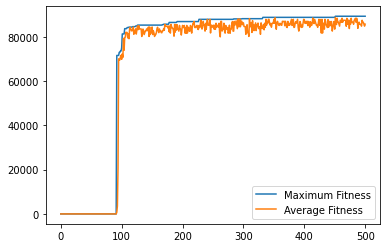

In [5]:
# Import myplot to show grafic
import matplotlib.pyplot as plt

# Select best individual of algorithm
best_individual = tools.selBest(result, k=1)[0]

# Convert distribution
best_distribution = create_distribution(best_individual)
print("Best distribution:")
print("--------------------")
# Format output
for distribution_idx, distribution in enumerate(best_distribution):
    print("Vehicle (LKW) " + str(distribution_idx + 1) + ": " + str([d[ORDER_NUMBER] for d in distribution]))
print("--------------------")
print("--> Best fitness: ", evaluation(best_individual)[0])

# Select statistics from learning process
record = stats.compile(result)
log.record(gen=0, evals=30, **record)
log.header = "gen", "avg", "max"

# Select values for plotting
gen = log.select("gen")[:-1]
fit_max = log.select("max")[:-1]
fit_avg = log.select("avg")[:-1]

# Plot generation number to fitness max and avarage
plt.plot(gen, fit_max, label="Maximum Fitness")
plt.plot(gen, fit_avg, label="Average Fitness")
plt.legend()
plt.show()

## Interpretation and evaluation of results
In the following we evaluate the results:
- We proposed a very modular solution. If more data would be added in the dataset files, the implemented algorithm will still work.
- Because of the very different capacities of each vehicle, more orders are distributed to vehicles with a larger capacity (for example vehicle 3 above has a total of 11 orders). When maximizing the revenue, it is advantageous to process many orders at one destination at once. This is why a vehicle with a larger capacity is optimal here.
- Sometimes vehicles do not get any orders assigned, because the maximum capacity is very low (vehicle number 6). If we would minimize the total time, each vehicle would probably be more evenly distributed.
- As can be seen in the plot, a valid population (for the defined contraints) is generated by chance most of the time in between 50 and 150 generations.
- After a valid population has been found, the increase of the maxmimum fitness is steep in the beginning and slows down over time.
- In the last few hundered generations, the average does not really change, but the maxmimum slightly improves.
- In most cases only a local maxmimum is found. To consistently find the global maximum, the algorithm would have to run with a bigger population size and more generations. Although this would lead to a longer execution time as well. The current implemented algorithm always runs about 4 seconds to execute the algorithm, which is a good compromise between execution time and result quality.

## Best values
Below you can see all calculated global maxima of the given dataset `Evo11_Auftraege.csv` and some selected best results (distributions) we could reach with the DEAP algorithm.

### Revenue
Global maximum for revenue (without contraints): 77.770 + 11.900 = **89.670** (all order revenues + all bonuses) 

```best_distribution = [[29, 7], [25, 20], [18, 19, 23, 8, 26, 12, 22, 9, 10, 17], [28, 1], [21, 14], [13, 24], [6, 15, 3, 2, 16], [0, 4, 27, 11, 5]]```

Found revenue: **89.670** (global maximum) 

### Bonus
Global maximum for bonus (without contraints): **11.900**

```best_distribution = [[7, 9], [2, 3, 11, 27, 13], [14, 20, 12, 8, 23, 26, 1, 10, 29], [0, 22, 15], [25, 17], [28, 19], [21, 4, 6, 5, 16], [18, 24]]```

Found bonus: **11.700**

### Penalty
Global maximum for penalty (without contraints): **27.500**

```best_distribution = [[], [], [9, 24, 11, 7, 18, 10, 0, 22, 8, 17, 6, 26, 25, 4, 14, 13, 12, 29, 16, 28, 19, 23, 21, 1, 3, 5, 2, 15], [27], [], [], [20], []]```

Found penalty: **26.700**

### Time
Global minimum for time (without contraints): **59**

```best_distribution = [[], [], [10, 26, 14, 0, 13, 29, 11, 9, 6, 18, 24, 8], [], [], [], [16, 2, 17, 3, 25, 27, 12, 28, 5, 4, 20, 19, 7, 23], [15, 1, 22, 21]]```

Minimal time: **104**